### Programming for Biomedical Informatics
#### Week 4 - Mining & Analysing the Biomedical Literature

Using some of the skills we've developed working with eUtils we're now going to do some literature mining and analysis to gather some evidence about a rare genetic disease called Rett Syndrome.

In [2]:
! pip install matplotlib_venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/44.5 MB 16.8 MB/s eta 0:00:03
   ------ --------------------------------- 6.8/44.5 MB 16.8 MB/s eta 0:00:03
   --------- ------------------------------ 11.0/44.5 MB 17.6 MB/s eta 0:00:02
   ------------- -------------------------- 15.2/44.5 MB 18.0 MB/s eta 0:00:02
   ----------------- ---------------------- 19.4/44.5 MB 18.3 MB/s eta 0:00:02
   -------------------- ------------------- 23.3/44.5 MB 18.2 MB/s eta 0:00:02
   ------------------------ --------------- 27.3/44.5 MB 18.4 MB/s eta 0:00:01
   ---------------------------- ----------- 31.5/

In [8]:
'''In this script we are going to directly query eUtils using the requests library. This is because it allows us to easily specify the parameters and use the history feature of eUtils to make large queries efficiently.
In the code below you should begin to see a pattern for how we approach the mapping process.'''

# Preliminaries
import urllib.request
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2 # need to download with pip (see above box) 

# we will use this to allow us to search the XML content retutned by the eUtils API
import xml.etree.ElementTree as ET

# load my API key from the file
with open('../../../pbi_mycourse/API Keys/ncbi.txt', 'r') as file:
    api_key = file.read().strip()

with open('../../../pbi_mycourse/API Keys/ncbi_email.txt', 'r') as file:
    email = file.read().strip()

In [ ]:
# Step 1 - Creating a specific search to find articles relating to Rett Syndrome

'''A good place to start is to search MeSH to see if a specific term for "Rett Syndrom" exists. If it does we can
use this to perform a PubMed search. Experimentally it makes sense to try a few different phrasings and methods
to search for Rett Syndrome to see how much the results vary.

https://meshb.nlm.nih.gov

It would make sense to do some analysis of this; for example we could retrieve the PubMedIds for the different searches
and comapre them to see how much overlap there is. This would give us confidence in our search strategy.'''

In [10]:
# Search PubMed for articles relating to Rett Syndrome using eUtils API
# Define the parameters for the eSearch request

'''as we're going to make a few different searches we can define a function to do this for us'''

def pubmed_search_count(query, api_key, email):

    # define the parameters for the eSearch request
    esearch_params = {
        'db': 'pubmed',
        'term': query,
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esaerch_data_XML = ET.fromstring(response.read())

    # extract the couunt of the number of articles found
    count = int(esaerch_data_XML.find('Count').text)

    print(f"Found {count} articles")

In [13]:
# try a search with the MeSH term for Rett Syndrome

pubmed_search_count('"Rett Syndrome"[MH]', api_key, email) # see nested speech marks 

Found 3073 articles


In [14]:
# now lets try an allfields search for Rett Syndrome

# general rett syndrome search without any key (field) tag - does an all fields search 
pubmed_search_count('Rett Syndrome', api_key, email)

Found 4710 articles


In [16]:
# lets modify the function above to return the list of PubMedIds

def pubmed_search_ids(query, api_key, email):
    
        # define the parameters for the eSearch request
        esearch_params = {
            'db': 'pubmed',
            'term': query,
            'api_key': api_key,
            'email': email
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

        # the base request url for eSearch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        esaerch_data_XML = ET.fromstring(response.read())

        # extract all the IDs in the response
        ids = [id.text for id in esaerch_data_XML.findall('IdList/Id')]

        return ids


# try a search with the MeSH term for Rett Syndrome
ids = pubmed_search_ids('"Rett Syndrome"[MH]', api_key, email)

# print the number of ids found
print(len(ids))

print(ids)

# only prints 20 id's and we know we have thousands, default of eutil is 20 entries 

20
['39384967', '39331775', '39305343', '39300547', '39269588', '39266326', '39258941', '39245841', '39232000', '39202466', '39138481', '39117159', '39074906', '39061009', '39033100', '39020317', '39003968', '39002354', '38997830', '38981105']


In [ ]:
'''so you can see the search by default will return 20 ids (you can modify retmax, but you'd need to adjust it based on the count return
which in effect would call the search twice. This is why we use the history feature of eUtils to make large queries efficiently)'''

In [30]:
# lets modify the function above to return the list of PubMedIds

def pubmed_search_ids(query, api_key, email):
    
        # define the parameters for the eSearch request
        esearch_params = {
            'db': 'pubmed',
            'term': query,
            'api_key': api_key,
            'email': email,
            'usehistory': 'y' # new addition  
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

        # the base request url for eSearch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        esearch_data_XML = ET.fromstring(response.read())

        # extract the WebEnv and QueryKey new additions 
        webenv = esearch_data_XML.find('WebEnv').text 
        query_key = esearch_data_XML.find('QueryKey').text

        # define the parameters for the eSummary request
        esummary_params = {
                'db': 'pubmed', 
                'query_key' : query_key,
                'webenv' : webenv,
                'api_key' : api_key,
                ' email' : email
        }

        # encode the parmeters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(esummary_params).encode('utf-8')

        # the base request url for eSummary
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request) # xml return 

        # read into an XML object
        esummary_data_XML = ET.fromstring(response.read())

        # extract all the IDs in the response
        ids = [id.text for id in esummary_data_XML.findall('DocSum/Id')]


        return ids

In [31]:
# try a search with the MeSH term for Rett Syndrome
q1_ids = pubmed_search_ids('"Rett Syndrome"[MH]', api_key, email)

# [romt the ;ength of the list of ids]
print(len(q1_ids))

3073


In [32]:
# try a search with the MeSH term for Rett Syndrome
q1_ids = pubmed_search_ids('"Rett Syndrome"[MH]', api_key, email)

# print the number of ids found
print(len(q1_ids))

3073


In [33]:
# and finally a Title and Abstract restricted search
q2_ids =pubmed_search_ids('Rett Syndrome[Title/Abstract]', api_key, email)

# print the number of ids found
print(len(q2_ids))

4127


In [34]:
#lets use pythons set comparison to see how many ids are in common between the three searches
common_ids = set(q1_ids).intersection(set(q2_ids))



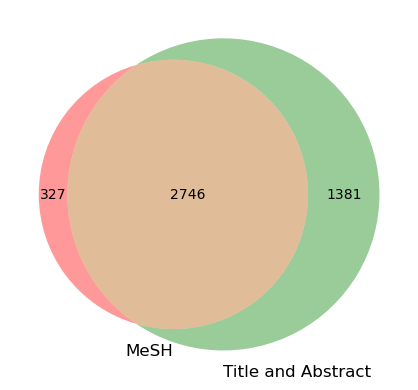

In [35]:
# using matplotlib_venn to plot a venn diagram of the results

# create the venn diagram
venn2([set(q1_ids), set(q2_ids)], ('MeSH', 'Title and Abstract'))

# show the plot
plt.show();

In [41]:
# We'll pick the first unique article from each search and retrieve the title and abstract

# define a function to retrieve the title, abstract and authors for a given PMID
def pubmed_fetch_tiab(pmid, api_key, email):
        
        # define the parameters for the eFetch request
        efetch_params = {
            'db': 'pubmed',
            'id': pmid,
            'retmode': 'xml',
            'api_key': api_key,
            'email': email
        }

        # encode the parameters so they can be passed to the API
        encoded_data = urllib.parse.urlencode(efetch_params).encode('utf-8')

        # the base request url for eFetch
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

        # make the request
        request = urllib.request.Request(url, data=encoded_data)
        response = urllib.request.urlopen(request)

        # read into an XML object
        efetch_data_XML = ET.fromstring(response.read())

        # remember we can print this to work out how to formulate the XML query
        print(ET.tostring(efetch_data_XML, encoding='utf8').decode('utf8'))

        # extract the title, abstract and MeSH terms
        for article in efetch_data_XML.findall('PubmedArticle'):
            title = article.find('MedlineCitation/Article/ArticleTitle').text # since its an element tree we only want the text value 
            abstract = article.find('MedlineCitation/Article/Abstract/AbstractText').text
            mesh_terms = [mesh_term.text for mesh_term in article.findall('MedlineCitation/MeshHeadingList/MeshHeading/DescriptorName')]

        return title, abstract, mesh_terms

In [43]:

# find the list of pmids that are unique to q1_ids
q1_unique_ids = list(set(q1_ids) - set(q2_ids)) # ids in q1 not in q2 
q2_unique_ids = list(set(q2_ids) - set(q1_ids)) # ids in q2 not in q1   

# call the function on the first element of the list 
pubmed_fetch_tiab(q1_unique_ids[202], api_key, email)

<?xml version='1.0' encoding='utf8'?>
<PubmedArticleSet>
<PubmedArticle><MedlineCitation Status="MEDLINE" Owner="NLM"><PMID Version="1">28369421</PMID><DateCompleted><Year>2017</Year><Month>10</Month><Day>12</Day></DateCompleted><DateRevised><Year>2022</Year><Month>01</Month><Day>29</Day></DateRevised><Article PubModel="Print"><Journal><ISSN IssnType="Electronic">1460-2083</ISSN><JournalIssue CitedMedium="Internet"><Volume>26</Volume><Issue>12</Issue><PubDate><Year>2017</Year><Month>Jun</Month><Day>15</Day></PubDate></JournalIssue><Title>Human molecular genetics</Title><ISOAbbreviation>Hum Mol Genet</ISOAbbreviation></Journal><ArticleTitle>Searching for biomarkers of CDKL5 disorder: early-onset visual impairment in CDKL5 mutant mice.</ArticleTitle><Pagination><StartPage>2290</StartPage><EndPage>2298</EndPage><MedlinePgn>2290-2298</MedlinePgn></Pagination><ELocationID EIdType="doi" ValidYN="Y">10.1093/hmg/ddx119</ELocationID><Abstract><AbstractText>CDKL5 disorder is a neurodevelopmental

('Searching for biomarkers of CDKL5 disorder: early-onset visual impairment in CDKL5 mutant mice.',
 'CDKL5 disorder is a neurodevelopmental disorder still without a cure. Murine models of CDKL5 disorder have been recently generated raising the possibility of preclinical testing of treatments. However, unbiased, quantitative biomarkers of high translational value to monitor brain function are still missing. Moreover, the analysis of treatment is hindered by the challenge of repeatedly and non-invasively testing neuronal function. We analyzed the development of visual responses in a mouse model of CDKL5 disorder to introduce visually evoked responses as a quantitative method to assess cortical circuit function. Cortical visual responses were assessed in CDKL5 null male mice, heterozygous females, and their respective control wild-type littermates by repeated transcranial optical imaging from P27 until P32. No difference between wild-type and mutant mice was present at P25-P26 whereas de

In [ ]:


#define a function that will randomly pick a PMID from a list until one is found that has a title and abstract
def get_tiab_from_list(ids, api_key, email):
    '''### YOUR CODE HERE ###'''

# fetch the title and abstract for the random examples
q1_title, q1_abstract, q1_mesh_terms = get_tiab_from_list(q1_unique_ids, api_key, email)
q2_title, q2_abstract, q2_mesh_terms = get_tiab_from_list(q2_unique_ids, api_key, email)

# print the results for q1
# print the title ALLCAPS
'''### YOUR CODE HERE ###'''
# wrap the abstract at 80 characters
'''### YOUR CODE HERE ###'''
# print the mesh terms as a tab intended list one term per line
'''### YOUR CODE HERE ###'''

# print the results for q2 as well
'''### YOUR CODE HERE ###'''

In [ ]:
'''Now we want to try to learn something about Rett Syndrome from these papers.
One obvious thing to do is to see look at the distrubution of MeSH terms associated with the papers'''

In [ ]:
#define a function to retrieve all the MeSH terms for a list of PMIDs
def pubmed_fetch_mesh_terms(pmids, api_key, email):
    
    # define the parameters for the eFetch request
    efetch_params = {
        'db': 'pubmed',
        'id': ','.join(pmids),
        'retmode': 'xml',
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(efetch_params).encode('utf-8')

    # the base request url for eFetch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    efetch_data_XML = ET.fromstring(response.read())

    # extract the MeSH terms
    mesh_terms = []
    for article in efetch_data_XML.findall('PubmedArticle'):
        try:
            mesh_terms.extend([mesh.text for mesh in article.findall('MedlineCitation/MeshHeadingList/MeshHeading/DescriptorName')])
        except:
            pass

    # create a dictionary of the MeSH terms and their counts
    '''### YOUR CODE HERE ###'''
    
    return mesh_terms_dict

In [ ]:
#extract the MeSH term data for all the "Rett Syndrome[MH]" papers
pmids = q1_ids # this we derived right at the top of the notebook

mesh_dict = pubmed_fetch_mesh_terms(pmids, api_key, email)

# sort the dictionary by the counts
sorted_mesh_dict = '''### YOUR CODE HERE ###'''

# plot the top 10 MeSH terms
plt.barh(list(sorted_mesh_dict.keys())[:10], list(sorted_mesh_dict.values())[:10]);

'''What can we immediately learn from this data?'''

In [144]:
'''lets use eLink to find any OMIM records that refer to these papers.
Remember OMIM - Online Mendelian Inheritance in Man - is a curated database of human genes and genetic disorders'''

def get_pubmed_omim(pmids):

    # NB you can see all the links (an astonishing number)
    # https://eutils.ncbi.nlm.nih.gov/entrez/query/static/entrezlinks.html#pubmed
    # we are going to use the pubmed_omim_calculated link as this finds OMIM records that cite our papers

    # convert the list of pmids to a string where each pmid is preceded by 'id=' and separated by an &
    pmid_string = '&id='.join(pmids)
    
    # Define the parameters for the eSearch request
    # Notice how we don't have to specify the dbfrom and db elements if we use the linkname
    elink_params = {
        'linkname': 'pubmed_omim_calculated',
        'api_key': api_key,
        'email': email,
    }
    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(elink_params).encode('utf-8')
    encoded_data = encoded_data + pmid_string.encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)
    
    # read into an XML object
    elink_data_XML = ET.fromstring(response.read())

    # list to store the pubmed_ids of the cited papers
    omim_records = []

    # extract the gene ids from the links
    for link in elink_data_XML.findall('LinkSet/LinkSetDb/Link/Id'):
        omim_records.append(link.text)

    return omim_records

In [ ]:
# create a list of OMIM entries linked to the papers
omim_records = get_pubmed_omim(pmids)

# find the unique gene ids from the list
unique_omim_records = list(set(omim_records))

# print the number of unique records
print(f'There are',len(unique_omim_records),'unique OMIM records linked to the papers')

In [162]:
# use eSummary to retrieve the titles of the OMIM records
def get_omim_titles(omim_records):

    # convert the list of omim records to a string where each omim record is followed by a [MIM] in an 'OR' separated string
    omim_string = '''### YOUR CODE HERE ###'''
    
    # Define the parameters for the eSearch request
    esearch_params = {
        'db': 'omim',
        'term': omim_string,
        'api_key': api_key,
        'email': email,
        'usehistory': 'y'
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esearch_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esearch_data_XML = ET.fromstring(response.read())

    # extract the WebEnv and QueryKey
    webenv = esearch_data_XML.find('WebEnv').text
    query_key = esearch_data_XML.find('QueryKey').text

    # define the parameters for the eSummary request
    esummary_params = {
        'db': 'pubmed',
        'query_key': query_key,
        'WebEnv': webenv,
        'api_key': api_key,
        'email': email
    }

    # encode the parameters so they can be passed to the API
    encoded_data = urllib.parse.urlencode(esummary_params).encode('utf-8')

    # the base request url for eSearch
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"

    # make the request
    request = urllib.request.Request(url, data=encoded_data)
    response = urllib.request.urlopen(request)

    # read into an XML object
    esummary_data_XML = ET.fromstring(response.read())

    # extract the titles of the OMIM records
    omim_titles = {}

    for record in esummary_data_XML.findall('DocSum'):
        try:
            omim_id = record.find('Id').text
            omim_title = record.find('Item[@Name="Title"]').text
            omim_titles[omim_id] = omim_title
        except:
            pass

    return omim_titles

In [ ]:
# get the titles of the OMIM records
omim_titles = get_omim_titles(unique_omim_records)

# convert this into a dataframe where the index is the OMIM ID and the column is the title
'''### YOUR CODE HERE ###'''

In [ ]:
# count the number of times each OMIM record is cited from the omim_records list
omim_records_dict = {}

for record in omim_records:
    '''### YOUR CODE HERE ###'''

# sort the dictionary by the counts
sorted_omim_records_dict = '''### YOUR CODE HERE ###'''

#convert the dictionary to a dataframe
df_omim = pd.DataFrame.from_dict(sorted_omim_records_dict, orient='index', columns=['Count'])

# merge the dataframe with the omim_names dataframe
combined = '''### YOUR CODE HERE ###'''

#remove the index column
combined.reset_index(inplace=True)

#rename the columns
combined.columns = ['OMIM ID', 'Count', 'Title']

# print the dataframe
combined.head()

In [ ]:
# plot the top 10 OMIM records
'''### YOUR CODE HERE ###'''

In [ ]:
'''Well Done!'''